<a href="https://colab.research.google.com/github/Scrivane/AML_project_5/blob/main/Federated/first_federated_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#prova ── A. Imports & Reproducibility ────────────────────────────────────────────────
import os, copy
import csv                                                  # For result logging :contentReference[oaicite:0]{index=0}
import random                                               # For seeding :contentReference[oaicite:1]{index=1}
import numpy as np                                          # For numeric ops :contentReference[oaicite:2]{index=2}
import torch                                               # Core PyTorch :contentReference[oaicite:3]{index=3}
import torch.nn as nn                                       # Neural-net modules :contentReference[oaicite:4]{index=4}
import torch.nn.functional as F                             # Functional API :contentReference[oaicite:5]{index=5}
import torch.optim as optim                                 # Optimizers :contentReference[oaicite:6]{index=6}
from torch.optim.lr_scheduler import CosineAnnealingLR      # Scheduler :contentReference[oaicite:7]{index=7}
from torch.utils.data import DataLoader, random_split       # Data loaders & splits :contentReference[oaicite:8]{index=8}
import torchvision                                          # Datasets & transforms :contentReference[oaicite:9]{index=9}
import torchvision.transforms as T                          # Transforms :contentReference[oaicite:10]{index=10}
from torch.utils.tensorboard import SummaryWriter           # TensorBoard logging :contentReference[oaicite:11]{index=11}
import matplotlib.pyplot as plt                             # Plotting :contentReference[oaicite:12]{index=12}

In [ ]:
# Seed everything for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# ── B. Device ───────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")                             # Confirm GPU vs CPU :contentReference[oaicite:13]{index=13}



# ── C. Data Preparation ─────────────────────────────────────────────────────────
# Transforms
transform_train = T.Compose([
    T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])


Using device: cuda


In [ ]:
# ── C. Data Preparation ─────────────────────────────────────────────────────────
# Transforms (as before)…

# Download full CIFAR‑100 training set
full_train = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)

# 1) Centralized validation split
val_size   = 5000
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

# ── C.1 Build validation loader ───────────────────────────────
BS_VAL = 256
val_loader = DataLoader(
    val_dataset,
    batch_size=BS_VAL,
    shuffle=False,
    num_workers=2
)


# 2) IID sharding of the remaining train_dataset into K=100 clients
K = 100
shards = random_split(
    train_dataset,
    [train_size // K] * K,
    generator=torch.Generator().manual_seed(seed)
)

# 3) Global test set (unchanged)
test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test
)
bs_test = 256
test_loader = DataLoader(
    test_dataset, batch_size=bs_test, shuffle=False, num_workers=2
)

# 4) (Later) you can build per-client loaders:
# client_loaders = [
#     DataLoader(shards[i], batch_size=bs, shuffle=True, num_workers=2)
#     for i in range(K)
# ]


100%|██████████| 169M/169M [00:04<00:00, 42.2MB/s]


In [ ]:
# ── D. Model Definition ─────────────────────────────────────────────────────────
class LELeNetCIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*8*8, 384)
        self.fc2   = nn.Linear(384, 192)
        self.fc3   = nn.Linear(192, 100)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# ── E. Utilities: Train/Eval & Checkpointing ────────────────────────────────────
def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    running_loss = correct = total = 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward(); optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        correct += out.argmax(1).eq(lbls).sum().item()
        total += lbls.size(0)
    return running_loss/total, correct/total

def eval_model(model, criterion, loader):
    model.eval()
    running_loss = correct = total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs); loss = criterion(out, lbls)
            running_loss += loss.item()*imgs.size(0)
            correct += out.argmax(1).eq(lbls).sum().item()
            total += lbls.size(0)
    return running_loss/total, correct/total



ckpt_dir = './checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)

def save_checkpoint(model, round_num, is_best=False):
    """
    Save the global model state at a given federated round,
    along with RNG state for reproducibility. Optionally keep a best-model file.
    """
    state = {
        'round': round_num,
        'model_state': model.state_dict(),
        'rng_state': torch.get_rng_state(),
    }
    fname = f"{'best' if is_best else 'last'}_ckpt_round_{round_num}.pth"
    torch.save(state, os.path.join(ckpt_dir, fname))

    if is_best:
        torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_model.pth'))


In [ ]:
# ── A. FedAvg Hyperparameters ───────────────────────────────────────────────────
# Fixed FL parameters
K      = 100      # total clients
C      = 0.1      # fraction of clients sampled per round
J      = 4        # local epochs per client
ROUNDS = 200  #2000     # total communication rounds

# Optimizer hyperparameters (constant, no schedule)
LR     = 0.01     # fixed learning rate
WD     = 1e-4     # weight decay
BS     = 128      # per-client batch size

# ── Instantiate TensorBoard writer ──────────────────────────────────────────────
from torch.utils.tensorboard import SummaryWriter
log_dir   = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)

# ── B. CSV Logging Setup ────────────────────────────────────────────────────────
import csv, os
csv_path = './fedavg_results.csv'



# ── B. CSV Logging Setup ────────────────────────────────────────────────────────
import csv, os
csv_path = './fedavg_results.csv'
if not os.path.exists(csv_path):
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'round',
            'val_loss', 'val_acc',
            'test_loss', 'test_acc'
        ])

# Before your FedAvg loop: Instantiate the global model, loss, and client loaders once

global_model = LELeNetCIFAR().to(device)
criterion    = nn.CrossEntropyLoss()
client_loaders = [
    DataLoader(shards[i], batch_size=BS, shuffle=True, num_workers=2)
    for i in range(K)
]



# ── C. FedAvg Training Loop ─────────────────────────────────────────────────────
for rnd in range(1, ROUNDS + 1):
    # 1) Sample clients
    m = max(1, int(C * K))      # → 10 clients per round when K=100, C=0.1
    selected = random.sample(range(K), m)

    local_states, sizes = [], []
    for i in selected:
        # 2a) Copy global model
        client_model = copy.deepcopy(global_model)
        client_model.train()
        optimizer = optim.SGD(client_model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)

        # 2b) Local training for J epochs
        loader = client_loaders[i]
        for _ in range(J):
            train_one_epoch(client_model, optimizer, criterion, loader)

        local_states.append(client_model.state_dict())
        sizes.append(len(shards[i]))

    # 3) Weighted aggregation
    total_size = sum(sizes)
    new_state = {}
    for k in global_model.state_dict():
        new_state[k] = sum((sizes[j] / total_size) * local_states[j][k] for j in range(len(sizes)))
    global_model.load_state_dict(new_state)

    # 4) Global evaluation
    # 4a) Validation evaluation
    val_loss, val_acc = eval_model(global_model, criterion, val_loader)

    # 4b) Test evaluation
    test_loss, test_acc = eval_model(global_model, criterion, test_loader)

    # 5) Checkpoint & logging
    save_checkpoint(global_model, rnd, is_best=False)
    with open(csv_path, 'a', newline='') as f:
        csv.writer(f).writerow([rnd,
                                f"{val_loss:.4f}", f"{val_acc:.4f}",
                                f"{test_loss:.4f}", f"{test_acc:.4f}"])


    # 6) TensorBoard logging
    tb_writer.add_scalar('Accuracy/Validation', val_acc, rnd)
    tb_writer.add_scalar('Loss/Validation',    val_loss, rnd)
    tb_writer.add_scalar('Accuracy/Test',       test_acc, rnd)
    tb_writer.add_scalar('Loss/Test',           test_loss, rnd)


    if rnd % 10 == 0 or rnd == 1:
        print(f"Round {rnd}/{ROUNDS} → "
              f"Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


Round 1/200 → Val Acc: 0.0126, Test Acc: 0.0101
Round 10/200 → Val Acc: 0.0430, Test Acc: 0.0383
Round 20/200 → Val Acc: 0.0926, Test Acc: 0.0933
Round 30/200 → Val Acc: 0.1194, Test Acc: 0.1297
Round 40/200 → Val Acc: 0.1558, Test Acc: 0.1597
Round 50/200 → Val Acc: 0.1754, Test Acc: 0.1737
Round 60/200 → Val Acc: 0.1902, Test Acc: 0.1942
Round 70/200 → Val Acc: 0.2136, Test Acc: 0.2091
Round 80/200 → Val Acc: 0.2180, Test Acc: 0.2228
Round 90/200 → Val Acc: 0.2228, Test Acc: 0.2356
Round 100/200 → Val Acc: 0.2428, Test Acc: 0.2462
Round 110/200 → Val Acc: 0.2540, Test Acc: 0.2612
Round 120/200 → Val Acc: 0.2596, Test Acc: 0.2679
Round 130/200 → Val Acc: 0.2640, Test Acc: 0.2701
Round 140/200 → Val Acc: 0.2732, Test Acc: 0.2904
Round 150/200 → Val Acc: 0.2814, Test Acc: 0.2967
Round 160/200 → Val Acc: 0.2860, Test Acc: 0.3072
Round 170/200 → Val Acc: 0.3064, Test Acc: 0.3103
Round 180/200 → Val Acc: 0.3022, Test Acc: 0.3190
Round 190/200 → Val Acc: 0.3102, Test Acc: 0.3270
Round 200/2

In [ ]:
# ── Configuration Summary & Utilities for FedAvg ──────────────────────────────

import os, sys, platform, time
import torch
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter

# 1) Define and instantiate your TensorBoard writer
log_dir = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)

# 2) Summary utility
def summarize_run(cfg, client_loaders, test_loader, writer=None):
    """
    Print and log summary for a FedAvg run.
    """
    ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print(f"\n========== FEDAVG RUN SUMMARY ({ts}) ==========")
    # Hyperparameters
    for key in ['lr','weight_decay','batch_size','K','C','J','ROUNDS']:
        print(f"    • {key}: {cfg[key]}")
    # Data info
    num_clients  = len(client_loaders)
    shard_size   = len(client_loaders[0].dataset)
    test_samples = len(test_loader.dataset)
    print(f"    • clients (K): {num_clients}, shard size: {shard_size}")
    print(f"    • test samples: {test_samples}, batch size: {cfg['batch_size']}")
    # Log to TensorBoard
    if writer:
        for key in ['lr','weight_decay','batch_size','K','C','J','ROUNDS']:
            writer.add_text(f'RunInfo/{key}', str(cfg[key]), 0)

# 3) Checkpoint utility
ckpt_dir = './checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)

def save_checkpoint(model, round_num, is_best=False):
    """
    Save the global FedAvg model and RNG state.
    """
    state = {
        'round': round_num,
        'model_state': model.state_dict(),
        'rng_state': torch.get_rng_state(),
    }
    fname = f"{'best' if is_best else 'last'}_ckpt_round_{round_num}.pth"
    torch.save(state, os.path.join(ckpt_dir, fname))
    if is_best:
        torch.save(model.state_dict(), os.path.join(ckpt_dir, 'best_model.pth'))

# ── Example Usage ────────────────────────────────────────────────────────────────

cfg = {
    'lr':           LR,
    'weight_decay': WD,
    'batch_size':   BS,
    'K':            K,
    'C':            C,
    'J':            J,
    'ROUNDS':       ROUNDS
}

# Print and log your FedAvg setup before starting training:
summarize_run(cfg, client_loaders, test_loader, tb_writer)



========== FEDAVG RUN SUMMARY (2025-07-23 17:07:23) ==========
    • lr: 0.01
    • weight_decay: 0.0001
    • batch_size: 128
    • K: 100
    • C: 0.1
    • J: 4
    • ROUNDS: 200
    • clients (K): 100, shard size: 450
    • test samples: 10000, batch size: 128


First 5 rounds:


,round,val_loss,val_acc,test_loss,test_acc
0,1,4.6051,0.0094,4.6047,0.0128
1,1,4.6058,0.0088,4.6047,0.0088
2,2,4.6038,0.0098,4.6023,0.0104
3,3,4.6007,0.0108,4.5989,0.0106
4,4,4.5947,0.0144,4.5932,0.0125


Last 5 rounds:


,round,val_loss,val_acc,test_loss,test_acc
216,196,2.8674,0.3098,2.8004,0.3263
217,197,2.8692,0.3132,2.8002,0.3227
218,198,2.8722,0.3114,2.8280,0.3282
219,199,2.8540,0.3094,2.7958,0.3284
220,200,2.8901,0.3132,2.8066,0.3308


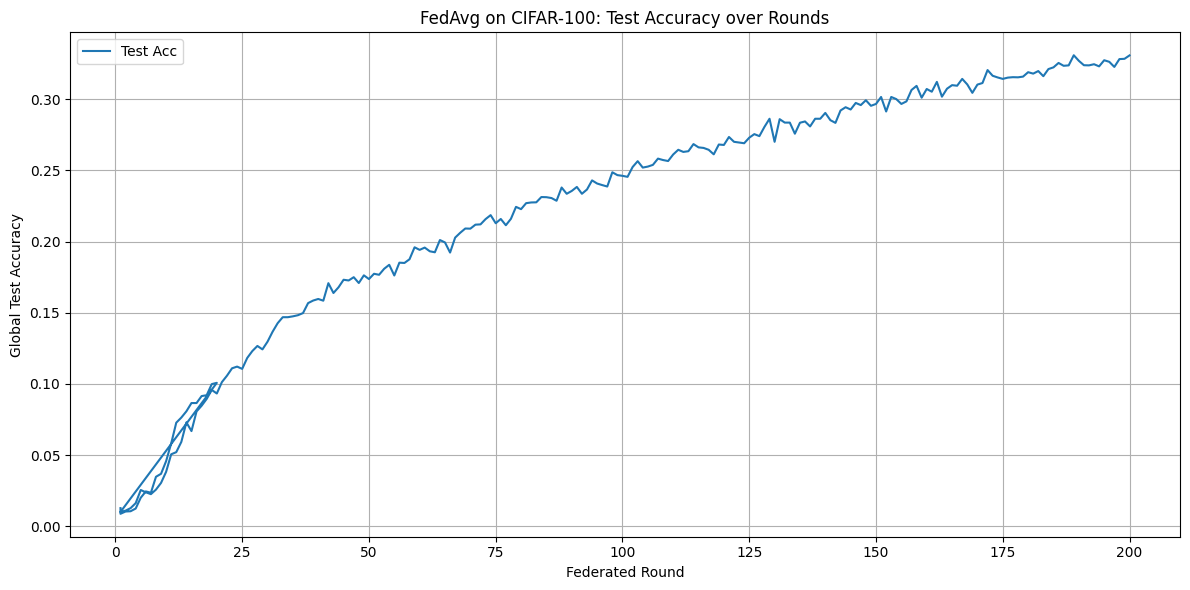

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the correct results file
csv_path = './fedavg_results.csv'    # update to your actual path
df = pd.read_csv(csv_path)

# 2. Inspect first/last entries
print("First 5 rounds:")
display(df.head())
print("Last 5 rounds:")
display(df.tail())

# 3. Plot Test Accuracy over Federated Rounds
plt.figure(figsize=(12, 6))
plt.plot(df['round'], df['test_acc'], label='Test Acc')
plt.xlabel('Federated Round')
plt.ylabel('Global Test Accuracy')
plt.title('FedAvg on CIFAR-100: Test Accuracy over Rounds')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


First rounds:


,round,val_loss,val_acc,test_loss,test_acc
0,1,4.6051,0.0094,4.6047,0.0128
1,1,4.6058,0.0088,4.6047,0.0088
2,2,4.6038,0.0098,4.6023,0.0104
3,3,4.6007,0.0108,4.5989,0.0106
4,4,4.5947,0.0144,4.5932,0.0125


Last rounds:


,round,val_loss,val_acc,test_loss,test_acc
216,196,2.8674,0.3098,2.8004,0.3263
217,197,2.8692,0.3132,2.8002,0.3227
218,198,2.8722,0.3114,2.8280,0.3282
219,199,2.8540,0.3094,2.7958,0.3284
220,200,2.8901,0.3132,2.8066,0.3308


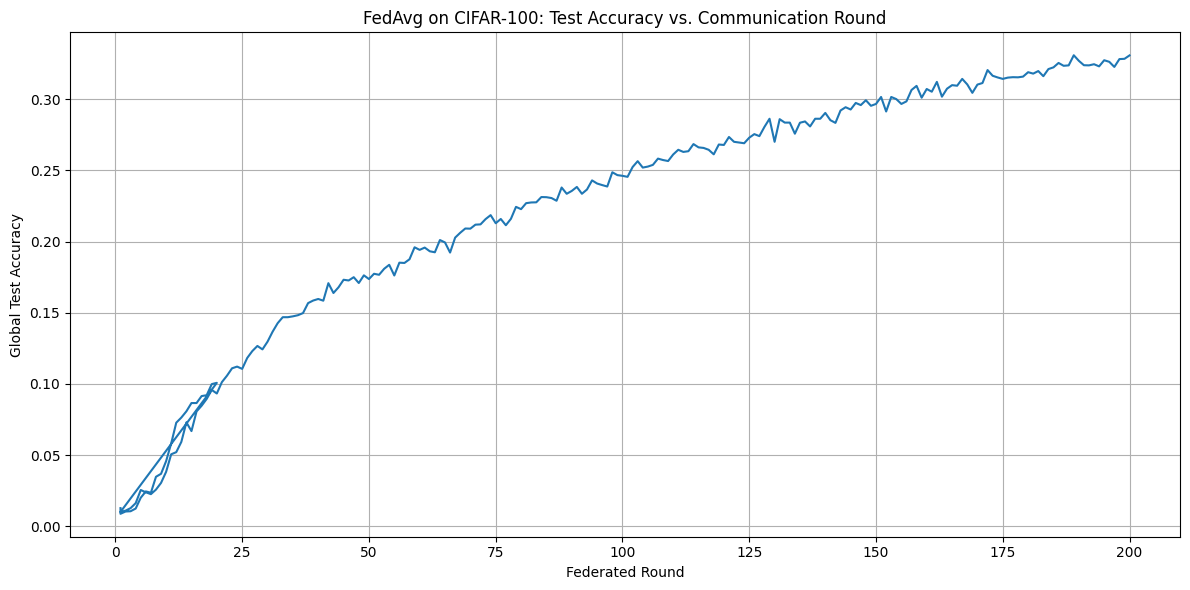

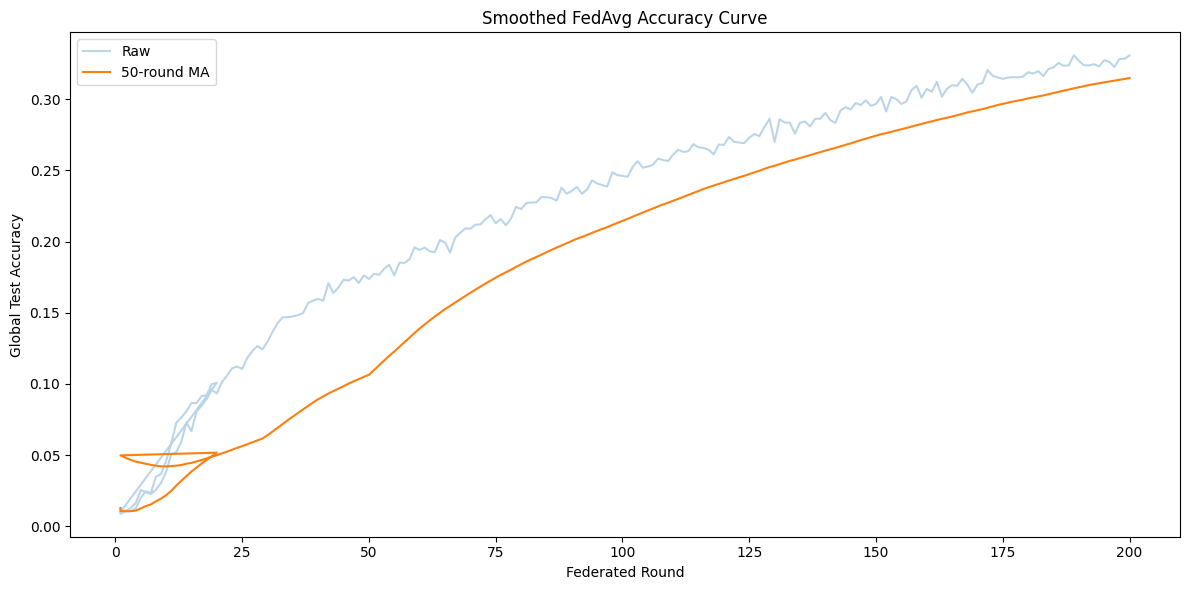

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load FedAvg results
csv_path = './fedavg_results.csv'
df = pd.read_csv(csv_path)

# 2. Quick peek at the first/last few entries
print("First rounds:")
display(df.head(5))
print("Last rounds:")
display(df.tail(5))

# 3. Plot Test Accuracy over Federated Rounds
plt.figure(figsize=(12, 6))
plt.plot(df['round'], df['test_acc'])
plt.xlabel('Federated Round')
plt.ylabel('Global Test Accuracy')
plt.title('FedAvg on CIFAR-100: Test Accuracy vs. Communication Round')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. (Optional) Smooth curve with rolling average
df['smoothed_acc'] = df['test_acc'].rolling(window=50, min_periods=1).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['round'], df['test_acc'], alpha=0.3, label='Raw')
plt.plot(df['round'], df['smoothed_acc'], label='50‐round MA')
plt.xlabel('Federated Round')
plt.ylabel('Global Test Accuracy')
plt.title('Smoothed FedAvg Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()
